## Библиотеки

In [75]:
import numpy as np
import pandas as pd
import pickle
%matplotlib widget
# import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from statistics import mode
from sklearn import model_selection #методы разделения и валидации
from sklearn.model_selection import StratifiedKFold
from requests import delete
import random as python_random
# Фиксируем seed для повторяемости результатов
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

In [76]:
# Для отмены вывода прогресс-бара
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
            
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = 0
        
        super().on_epoch_begin(epoch, *args, **kwargs)

## Функции

In [77]:
def get_amplitude(X):
    """
    Функция составляет словарь, 
    индекс словаря - индекс оси 1 входного массива,
    значение словаря - разница минимального и максимального 
    значения массива по оси 0.
    Аргумент: X - входной массив.
    Возвращает: словарь со значениями амплитуды."""
    
    ampl_dict = dict()                                   # Создаем словарь для значений амплитуды каждого датчика
    for i in range(X.shape[1]):
        curr_ampl = X[:,i].max()-X[:,i].min()    # Вычисляем амплитуду
        ampl_dict[i] = curr_ampl                         # Заносим значения амплитуды в словарь
    return ampl_dict

In [78]:
def cross_val_train_test_split(X, y, y_cat, kfold=5, cr_val=True):
    """
    Функция производит стратифицированное разделение обучающих выборок 
    на тренировочные и валидационные. 
    Аргументы:
    X - входной массив признаков,
    y - входной массив целевой переменной,
    y_cat - входной массив целевой переменной в категориальной форме,
    kfold - количество фолдов,
    cr_val - для валидации или кросс-валидации формировать выборки.
    Возвращает: список из массивов разделенных выборок.    
    """
    skf = StratifiedKFold(n_splits=kfold)
    split_Xy = []
    y_cv_mark = y[:,0,0]  # метка для стратификации
    X_cv_ind = list(range(X.shape[0]))
    
    for train_ind, valid_ind in skf.split(X_cv_ind, y_cv_mark):
        X_train_nn_i, y_train_nn_i = X[train_ind], y_cat[train_ind]
        X_valid_nn_i, y_valid_nn_i = X[valid_ind], y_cat[valid_ind]
    
        split_Xy.append((X_train_nn_i, X_valid_nn_i, y_train_nn_i, y_valid_nn_i))
        
        if not(cr_val):
            print(f"Валидация, размер валидационной выборки {1/kfold}")
            return split_Xy
    if cr_val:
        print(f"Кросс-валидация, количество фолдов {kfold}")
    return split_Xy    
    

In [79]:
def get_pilot_activ_sens(X, tres=200, vis=False):
    """
    Функция составляет множество активных датчиков, где:
    Индекс словаря - номер датчика,
    Значение 1 - амплитуда сигнала данного датчика превышает порог,
    Значение 0 - сигналы данного датчика не несут полезной информации.
    
    Аргументы: X - входной массив,
               tres - пороговое значение амплитуды датчика
               vis - вывод графиков, если True.
    Возвращает: мноожество активных датчиков."""
    
    global mount_name
    ampl_dict = get_amplitude(X)
    # Формируем словарь датчиков, амплитуда сигналов которых превышает порог 
    sens_dict = {key:1 for key, val in ampl_dict.items() if val > tres}
    
    if vis:
        fig, axx = plt.subplots(1, 1, sharex=True, figsize=(12, 2))
        axx.set_xlim([-1,50])
        plt.bar(ampl_dict.keys(), ampl_dict.values(), color='g')
        # Проводим горизонтальные линии, отделяющие активные датчики от неактивных
        plt.axhline(tres, color='r', linewidth=1)
        # Наносим на график значение порога
        plt.annotate(str(tres), xy =(-2, tres+80), color = 'red', fontsize = 10)
        plt.title(f"Распределение амплитуды сигнала по датчикам. Пилот №{mount_name}")
        plt.tight_layout()
        plt.show()
     
        fig, axx = plt.subplots(1, 1, sharex=True, figsize=(12, 2))
        axx.set_xlim([-1,50])
        plt.bar(sens_dict.keys(), sens_dict.values(), color='g')
        data_tck = list(sens_dict.keys())
        plt.xticks(ticks=data_tck)
        plt.title(f"Датчики, отобранные после пороговой фильтрации, пилот №{mount_name}")
        plt.tight_layout()
        plt.show()
    return set(sens_dict.keys())       
               


In [80]:
def get_predict_FR(X, m, n_tic):
    """
    Функция формирует предикт. 
    Аргументы:
    X - входной массив признаков форматом (N, N_sensors),
    m - обученная модель,
    n_tic - количество тиков в окне, которое поступает на вход модели.
    Возвращает: массив из значений форматом (N, 1).    
    """
    y_pred = np.zeros((1, 1), dtype=int)
    
    for i in range(X.shape[0]//n_tic):
        X_i = np.expand_dims(X[i*n_tic:(i+1)*n_tic], axis = 0)
        y_pred_i = m.predict(X_i,
            # Set the verbosity level here! This is important.
        callbacks=[SelectiveProgbarLogger(verbose = 0)], 
        # This disables the default `ProgbarLogger`
        verbose=0).argmax(axis=-1)
        
        y_pred_i = mode(y_pred_i[0])
        y_pred= np.hstack((y_pred, np.full((1, n_tic),y_pred_i)))
        
    y_pred = np.delete(y_pred, 0, axis=1).astype(int)
    # Дополним в конце список предиктов до полного соответствия массиву признаков
    last_pred = y_pred[0,-1]
    y_pred= np.hstack((y_pred, np.full((1, X.shape[0]%n_tic), last_pred)))
    return y_pred

## Загрузка и описание данных

In [81]:
# Формируем главный словарь для хранения переменных для каждого пилота
mounts = {
    1 : {
        'path_X_train' : './X_train_1.npy',
        'path_y_train' : './y_train_1.npy',
        'path_X_test_dataset' : './X_test_dataset_1.pkl',
    },
    2 : {
        'path_X_train' : './X_train_2.npy',
        'path_y_train' : './y_train_2.npy',
        'path_X_test_dataset' : './X_test_dataset_2.pkl',
    },
    3 : {
        'path_X_train' : './X_train_3.npy',
        'path_y_train' : './y_train_3.npy',
        'path_X_test_dataset' : './X_test_dataset_3.pkl',
    }
}

In [82]:
# Загружаем тренировочные и тестовые выборки 
for mount_name, mount in mounts.items():
    mount['X_train'] = np.load(mount['path_X_train'])
    mount['y_train'] = np.load(mount['path_y_train'])
    with open(mount['path_X_test_dataset'], 'rb') as f:
        mount['X_test_dataset'] = pickle.load(f)

## Изучение данных

Визуализируем обучающие выборки.

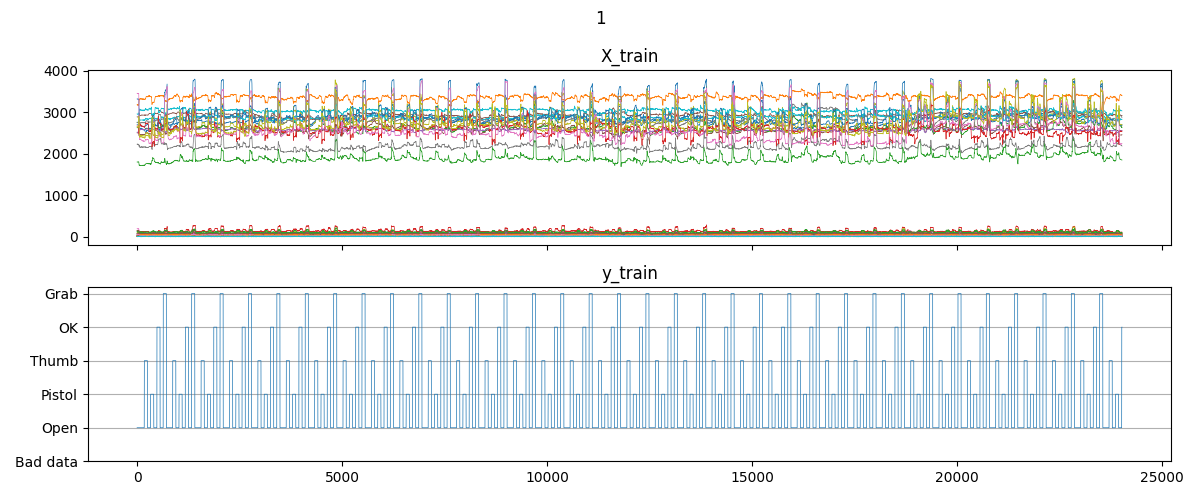

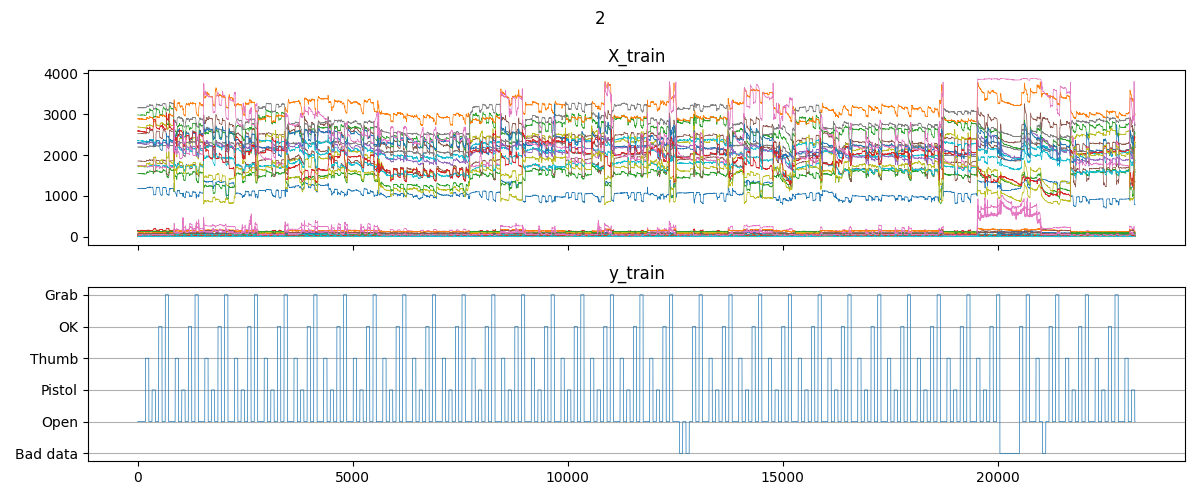

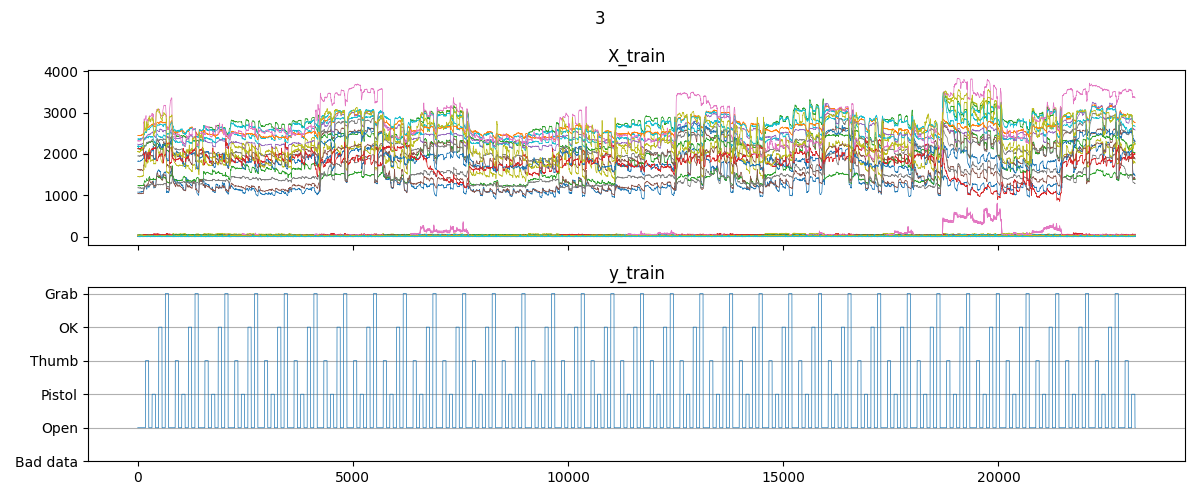

In [83]:
for mount_name, mount in mounts.items():
    X_train = mount['X_train']
    y_train = mount['y_train']
    
    #events = np.where(np.abs(np.diff(y_train)) > 0)[0]
    
    fig, axx = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
    plt.sca(axx[0])
    plt.plot(X_train, lw=0.5)
    plt.title('X_train')
    yl = plt.ylim()
    #plt.vlines(events, *yl, color='r', lw=0.5, alpha=0.5)
    
    plt.sca(axx[1])
    plt.plot(y_train, lw=0.5)
    plt.title('y_train')
    yl = plt.ylim()
    #plt.vlines(events, *yl, color='r', lw=0.5, alpha=0.5)
    plt.yticks(
        np.arange(-1, 5),
        ['Bad data', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
    )
    plt.grid(axis='y')
    
    plt.suptitle(f"{mount_name}")
    plt.tight_layout()
    plt.show()

Сигналы от датчиков сильно различаются по амплитуде. Есть группа датчиков, амплитуда сигналов которых находится на уровне шума.

В обучающих выборках содержится по 33-34 команды каждого жеста.

## Очистка данных

Рассмотрим амплитуды сигналов датчиков для каждого пилота.  
Произведем ортбор активных датчиков, амплитуда сигнала которых превышает порог.  
На основании графиков амплитуды выбираем порог tres = 200.  
Формируем множество датчиков, являющихся активными для всех пилотов

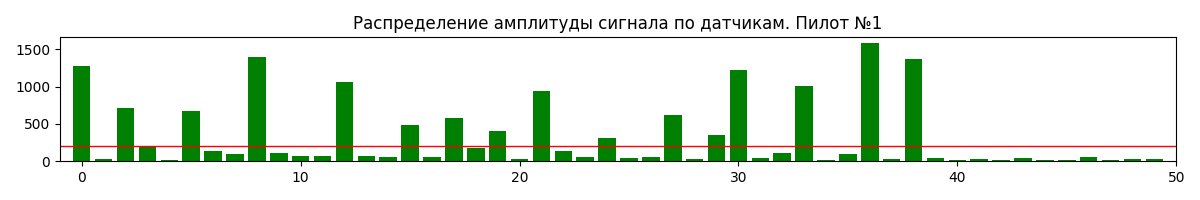

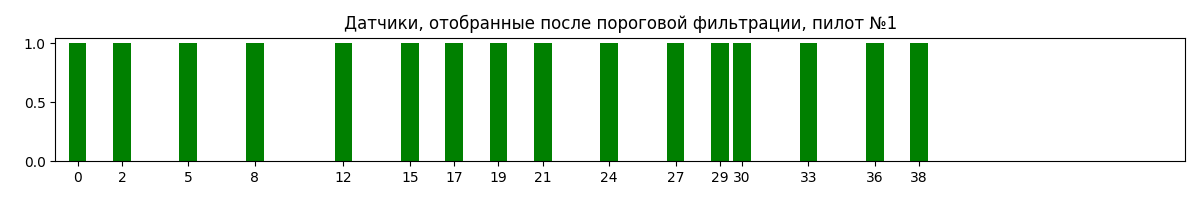

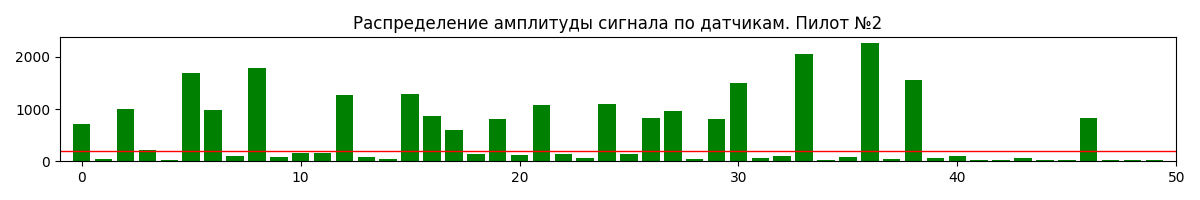

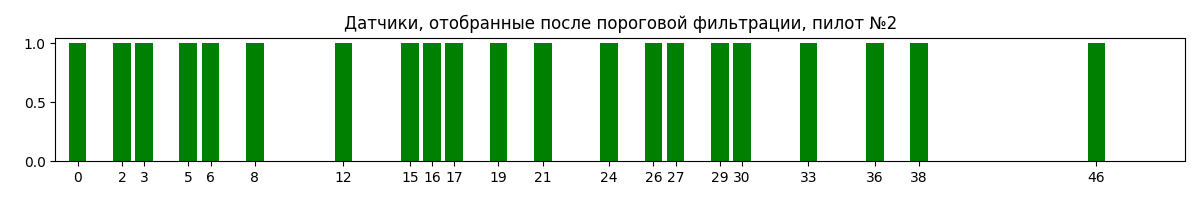

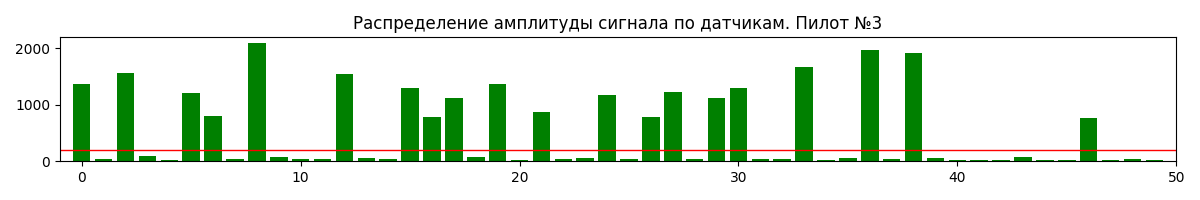

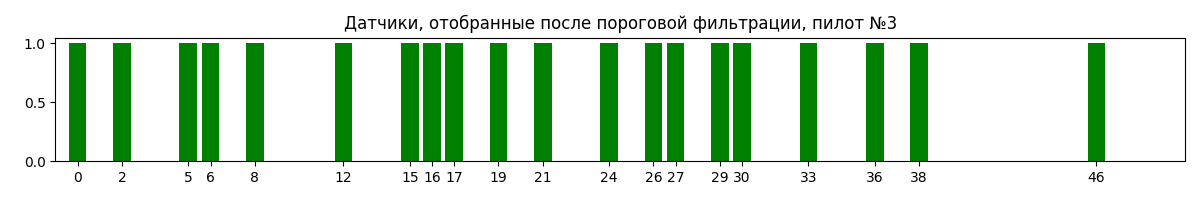

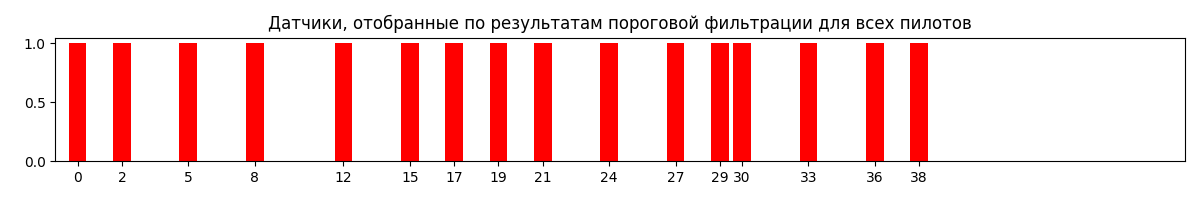

По результатам пороговой фильтрации отобрано 16 датчиков.
Множество активных датчиков:
{0, 33, 2, 36, 5, 38, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30}


In [84]:
activ_sens_set_comm = set(np.arange(50)) # Множество датчиков, являющихся активными для всех пилотов

for mount_name, mount in mounts.items():
    
    X_train = mount['X_train']
    activ_sens_set = get_pilot_activ_sens(X_train, 200, vis=True)
    activ_sens_set_comm = activ_sens_set_comm & activ_sens_set
    
    # Отфильтруем тренировочные выборки используя список активных датчиков 
    # и занесем отфильтрованные массивы в словарь mounts
    X_train_sel  = X_train[:, list(activ_sens_set_comm)]
    mount['X_train_sel'] = X_train_sel
    
fig, axx = plt.subplots(1, 1, sharex=True, figsize=(12, 2))
plt.bar(list(activ_sens_set_comm), np.full((len(activ_sens_set_comm)), 1), color='r')
data_tck = list(activ_sens_set_comm)
plt.xticks(ticks=data_tck)
axx.set_xlim([-1,50])
axx.set_title('Датчики, отобранные по результатам пороговой фильтрации для всех пилотов', fontsize=12)
plt.tight_layout() 
plt.show()


N_sensors = len(activ_sens_set_comm)
print(f'По результатам пороговой фильтрации отобрано {N_sensors} датчиков.')
print( 'Множество активных датчиков:')
print(activ_sens_set_comm)    

Амплитуда сигнала с датчиков 3, 6, 16, 26, 46 сильно отличается для разных пилотов.  
Рассмотрим эти датчики подробнее.

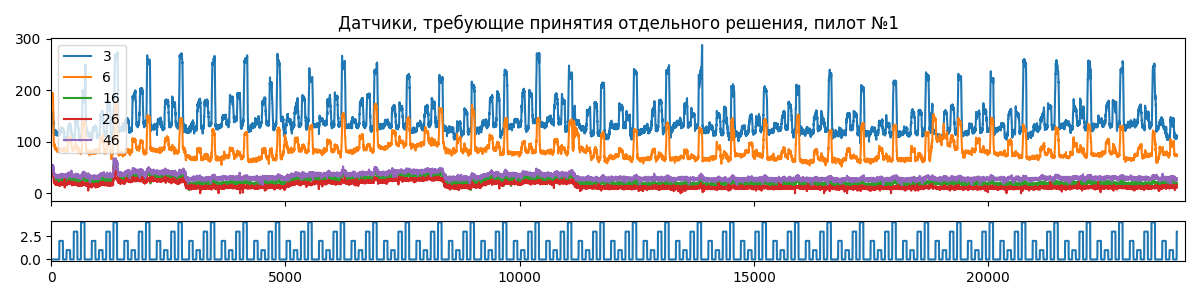

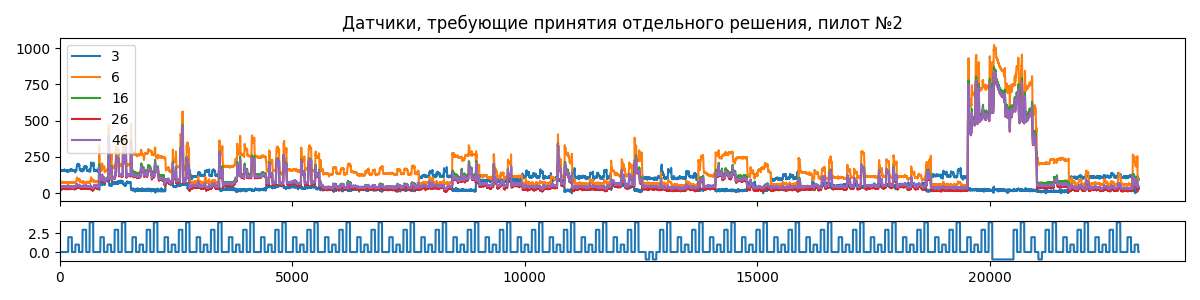

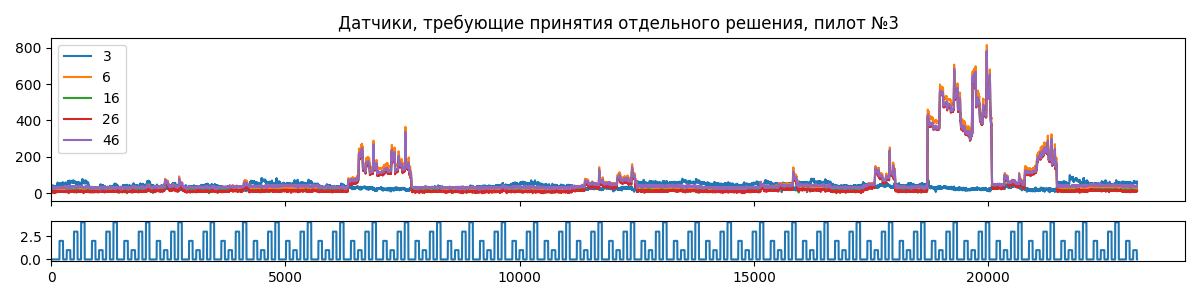

In [85]:
# Список датчиков, требующих уточнения
doubt_sensor_list = [3, 6, 16, 26, 46]

for mount_name, mount in mounts.items():
    X_train = mount['X_train']
    y_train = mount['y_train']
    fig, axx = plt.subplots(2, 1, sharex=True, figsize=(12, 3), gridspec_kw={'height_ratios': [4,1]})
    #plt.sca(axx[0])
    axx[0].set_title(f"Датчики, требующие принятия отдельного решения, пилот №{mount_name}", fontsize=12)
    axx[0].set_xlim(0,24200)
    axx[0].plot(X_train[:,doubt_sensor_list])
    axx[1].plot(y_train)
    axx[0].legend(doubt_sensor_list, loc='upper left')
    
    
    plt.tight_layout()
    plt.show()

Сигналы датчиков 3 и 6 имеют видимую корреляцию с целевой переменной.  
Вывод 1: для пилота №1 целесообразно добавить в список активных датчики 3 и 6.  

Рассмотрим подробнее датчики 3 и 6 для пилотов №2 и №3.

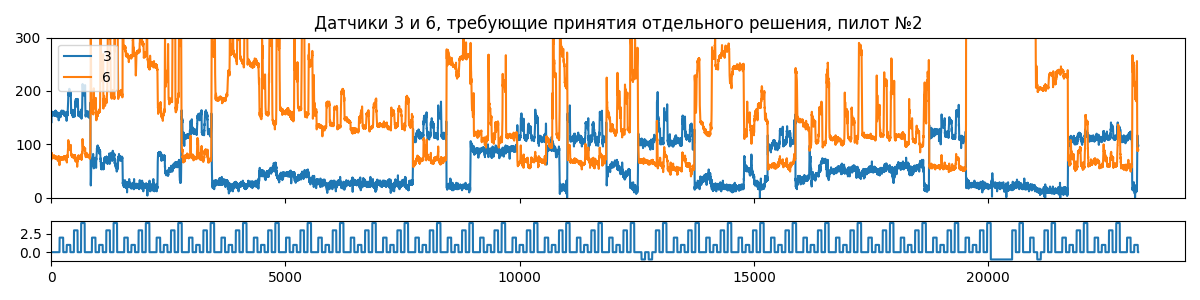

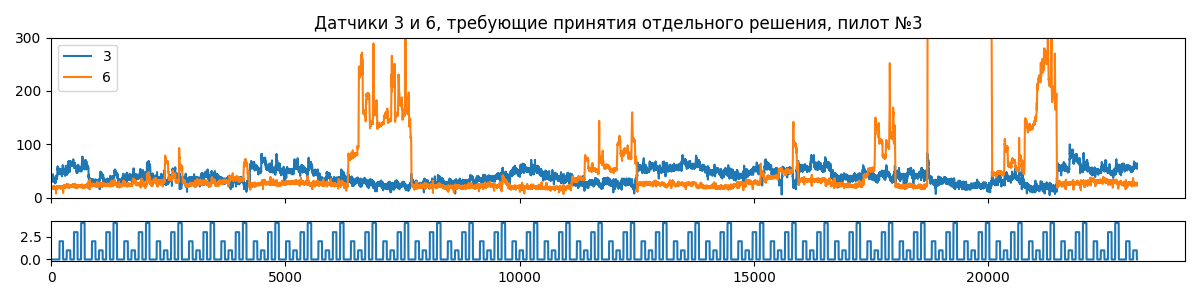

In [86]:
for mount_name in [2,3]:
    X_train = mounts[mount_name]['X_train']
    y_train = mounts[mount_name]['y_train']
    fig, axx = plt.subplots(2, 1, sharex=True, figsize=(12, 3), gridspec_kw={'height_ratios': [4,1]})
    #plt.sca(axx[0])
    axx[0].set_title(f"Датчики 3 и 6, требующие принятия отдельного решения, пилот №{mount_name}", fontsize=12)
    axx[0].set_xlim(0,24200)
    axx[0].set_ylim(0,300)
    axx[0].plot(X_train[:,[3, 6]])
    axx[1].plot(y_train)
    axx[0].legend([3, 6], loc='upper left')
    
    
    plt.tight_layout()
    plt.show()

Сигналы датчиков 3 и 6  не имеют видимой корреляции с целевой переменной.  
Вывод 2: датчики 3 и 6 целесообразно исключить из списка активных датчиков для пилотов №2 и №3.  

Рассмотрим подробнее датчики 26 и 46 для пилотов №2 и №3. 

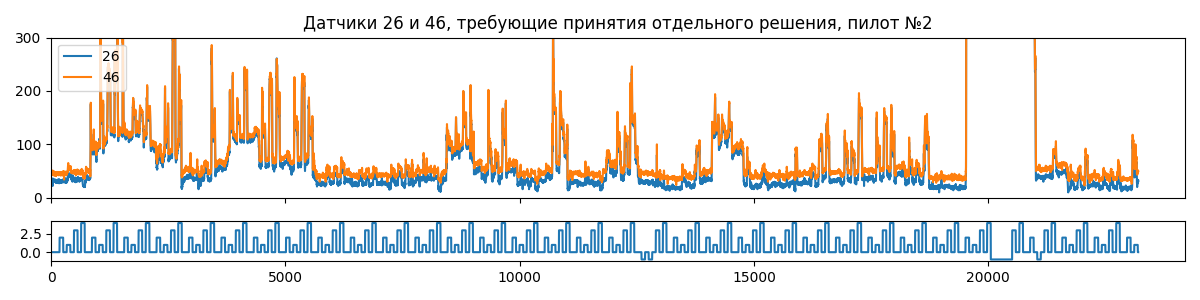

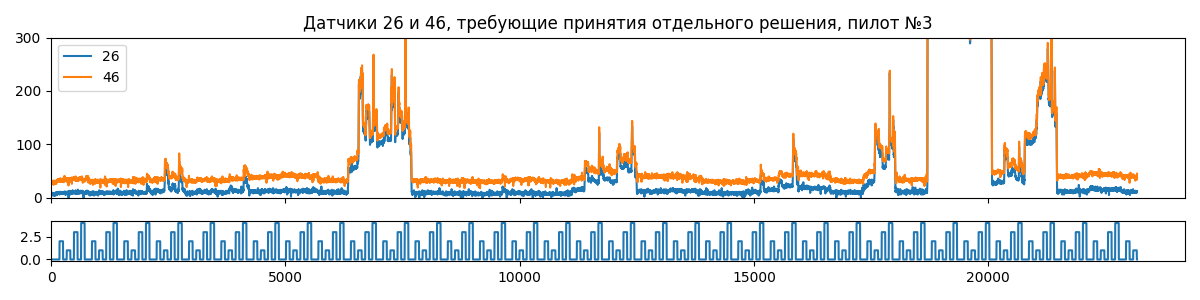

In [87]:
for mount_name in [2,3]:
    X_train = mounts[mount_name]['X_train']
    y_train = mounts[mount_name]['y_train']
    fig, axx = plt.subplots(2, 1, sharex=True, figsize=(12, 3), gridspec_kw={'height_ratios': [4,1]})
    #plt.sca(axx[0])
    axx[0].set_title(f"Датчики 26 и 46, требующие принятия отдельного решения, пилот №{mount_name}", fontsize=12)
    axx[0].set_xlim(0,24200)
    axx[0].set_ylim(0,300)
    axx[0].plot(X_train[:,[26, 46]])
    axx[1].plot(y_train)
    axx[0].legend([26, 46], loc='upper left')
    
    
    plt.tight_layout()
    plt.show()

Сигналы датчиков 26 и 46  не имеют явной корреляции с целевой переменной.  
Вывод 3: датчики 26 и 46 целесообразно исключить для всех пилотов.  

Суммируем выводы.  
Вывод 1: для пилота №1 , возможно, целесообразно добавить в список активных датчики 3 и 6.  
Вывод 2: датчики 3 и 6 целесообразно исключить из списка активных датчиков для пилотов №2 и №3.  
Вывод 3: датчики 26 и 46 целесообразно исключить для всех пилотов.  
**Итого**  
 - Для пилота №1 список активных датчиков состоит из общих для всех 16-ти датчиков, собранных в ***activ_sens_set_comm*** с добавлением датчиков 3 и 6.  
 *Дальнейшие исследования показали, что сигналы датчиков пилота №1 самые чистые и обеспечивают гораздо более лучшее распознавание по сравнению с остальными пилотами. Было принято решение не добавлять датчики.*
 - Для пилотов №2 и №3 список активных датчиков состоит из общих для всех 16-ти датчиков, собранных в ***activ_sens_set_comm***


### Апдейт по результатам эксперимента.  
При прочих равных условиях добавление датчиков 3 и 6 для обучения модели пилота №1 привело к ухудшению итоговых метрик. Этот вариант исключен из дальнейшей обработки.

## Предварительная обработка массива входных данных.

Сигналы датчиков имеют естественную задержку относительно подаваемых команд, связанную со временем реакции пилота.

Поскольку в обучающих выборках содержится по 33-34 команды каждого жеста, для увеличения количества обучающих выборок было принято решение выделить каждый жест, разбить его на несколько окон *frames*, сопоставив каждому окну значение целевой переменной.  
В результате экспериментов были определены оптимальные значения количества окон разбиения жеста *n_frames* и тиков в каждом окне *n_ticks*.  
Для компенсации задержки начала жеста относительно команды произведем сдвиг на величину *shift_gest_beg*. 

### Подбираемые параметры

In [88]:
# Параметры подобраны по максимумам метрики, расчет которой представлен ниже.

# Пилоты отличаются скоростью реакции на команды
# Введем индивидуальное значение задержки начала жеста
mounts[1]['shift_gest_beg'] = 10
mounts[2]['shift_gest_beg'] = 5   
mounts[3]['shift_gest_beg'] = 5

n_frames = 5      # количество окон разбиения жеста       
n_ticks = 16        # количество тиков в каждом окне
gest_len = n_frames*n_ticks   # анализируемая длительность жеста
# количество эпох обучения
mounts[1]['epochs_1'] = 100
mounts[2]['epochs_1'] = 100    
mounts[3]['epochs_1'] = 100
  
epochs_2 = 10   # количество эпох дообучения
learning_rate_1 = 1e-2  # скорость обучения
learning_rate_2 = 1e-3  # скорость дообучения

name = '32'   # Имя файла для сохранения модели


Пример таблицы для предварительного отбора параметров. Код формирования файла и таблицы представлен ниже.

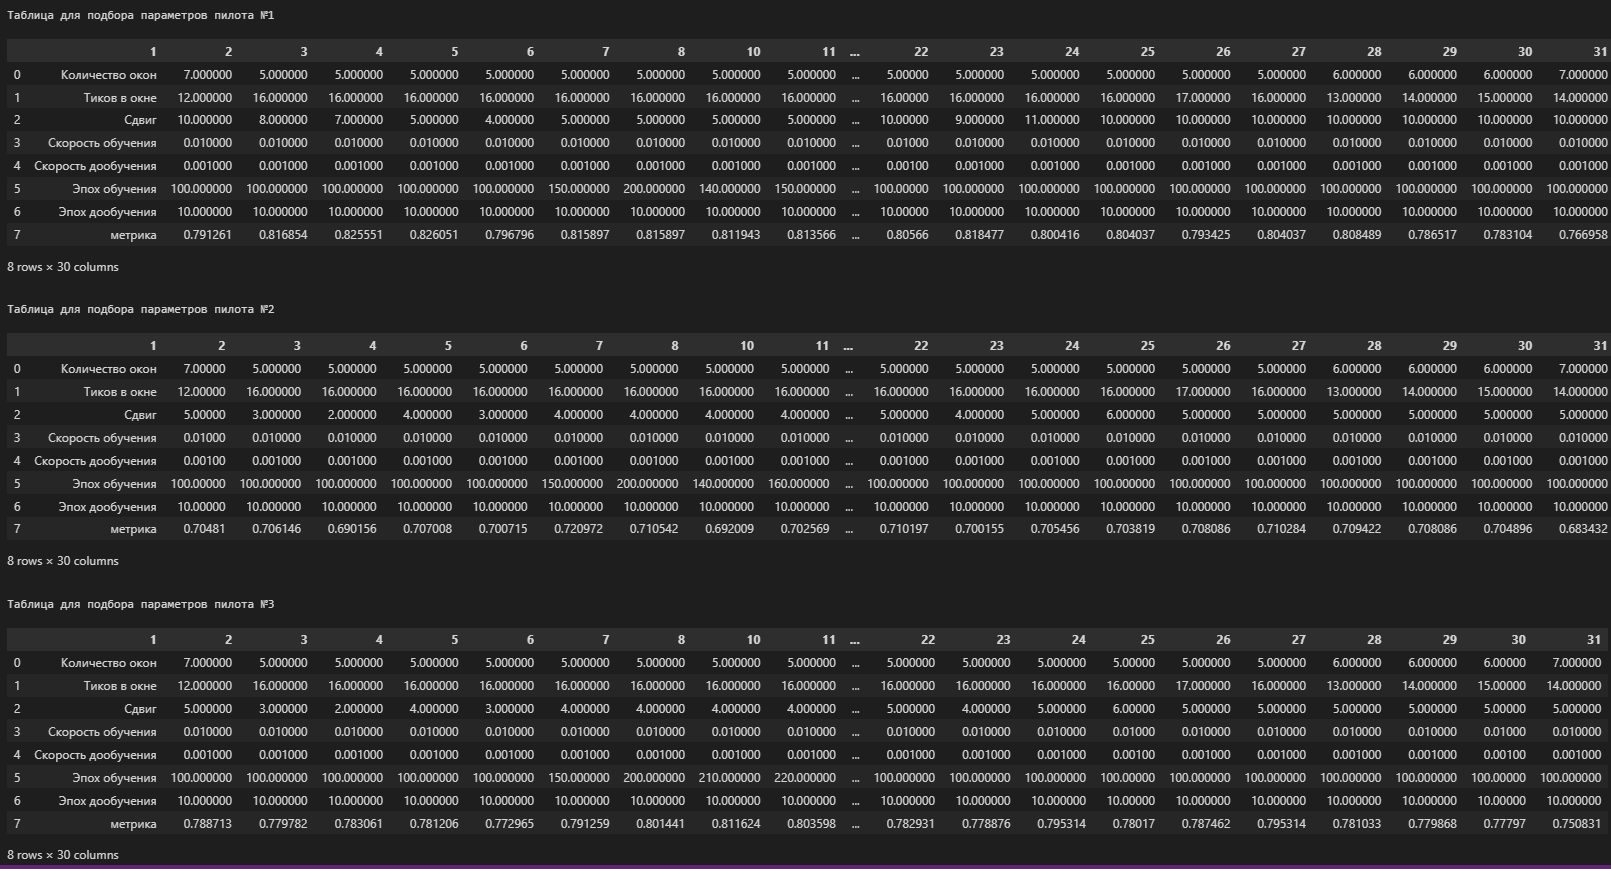

In [89]:
from IPython.display import Image
Image("./param_choice_3.PNG")

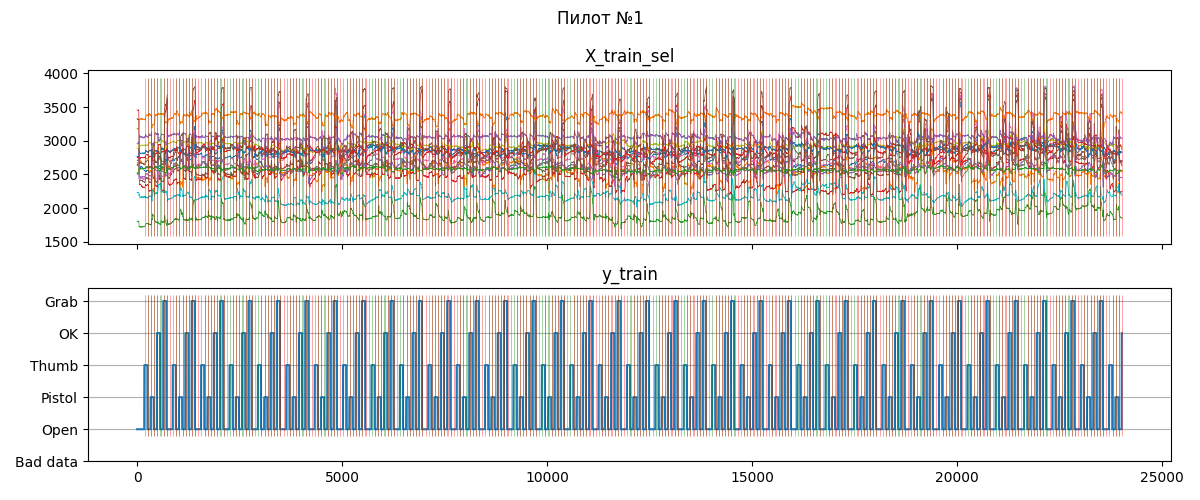

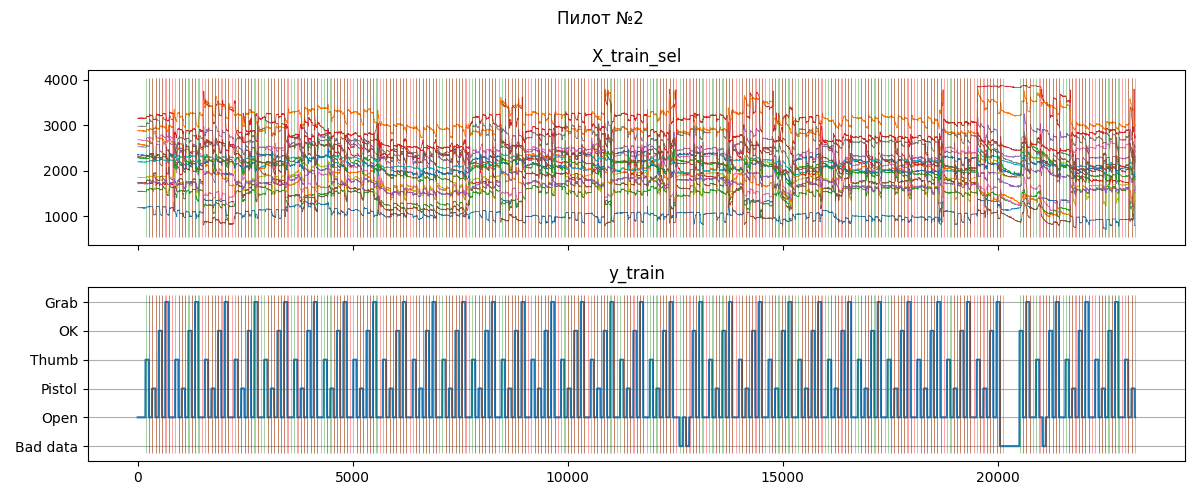

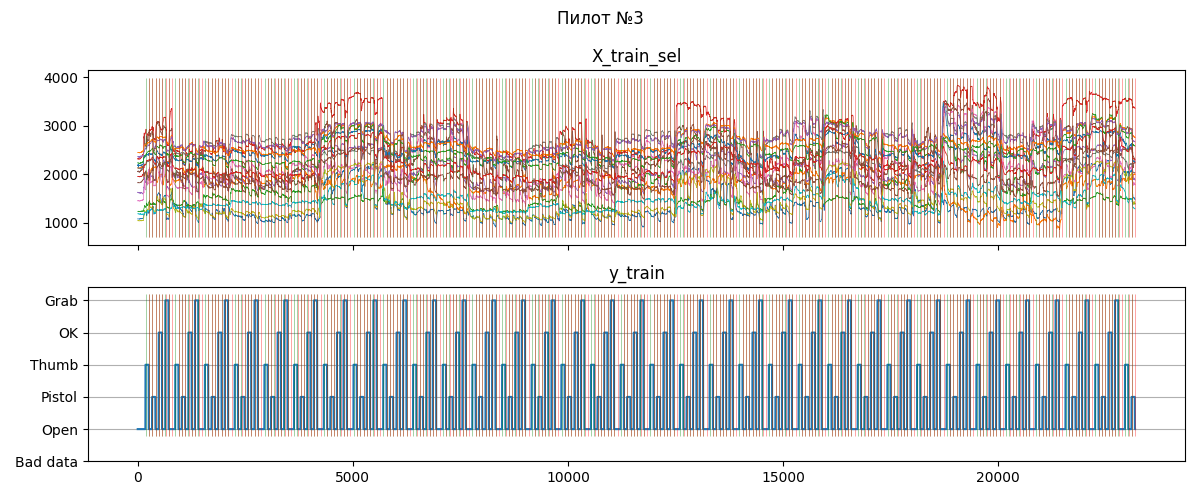

In [90]:
# Нанесем на графики границы жестов

for mount_name, mount in mounts.items():
    shift_b = mount['shift_gest_beg']
    
    X_train_sel = mount['X_train_sel']
    y_train = mount['y_train']
    
    # Определим моменты смены команд    
    events = np.where(np.abs(np.diff(y_train)) > 0)[0] 
    # Удалим последний жест - пустой или незаконченный
    events = np.delete(events, -1)
    # Точки начала анализируемой длительности жеста    
    events_b = events + shift_b
    # Точки конца анализируемой длительности жеста
    events_e = events + shift_b + gest_len
    
    # Заносим значения в главный словарь      
    mount['events'] = events
    mount['events_b'] = events_b
    mount['events_e'] = events_e
    
    # ВИЗУАЛИЗАЦИЯ
    # Вертикальные зеленые линии - координаты начала, красные - конца.
    fig, axx = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
    plt.sca(axx[0])
    plt.plot(X_train_sel, lw=0.5)
    plt.title('X_train_sel')
    yl = plt.ylim()
    plt.vlines(events_b, *yl, color='g', lw=0.5, alpha=0.5)
    plt.vlines(events_e, *yl, color='r', lw=0.5, alpha=0.5)
    plt.sca(axx[1])
    plt.plot(y_train)
    plt.title('y_train')
    yl = plt.ylim()
    plt.vlines(events_b, *yl, color='g', lw=0.5, alpha=0.5)
    plt.vlines(events_e, *yl, color='r', lw=0.5, alpha=0.5)
    plt.yticks(
        np.arange(-1, 5),
        ['Bad data', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
    )
    plt.grid(axis='y')
    
    plt.suptitle(f"Пилот №{mount_name}")
    plt.tight_layout()
    plt.show();
    

### Разбиение на окна и формирование нового массива обучающих выборок

(1380, 16, 16) (1380, 16, 1) (1380, 16, 5)


C:\Users\Rui\AppData\Local\Temp\ipykernel_5924\2615006744.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axx = plt.subplots(2, 1, sharex=True, figsize=(12, 5))


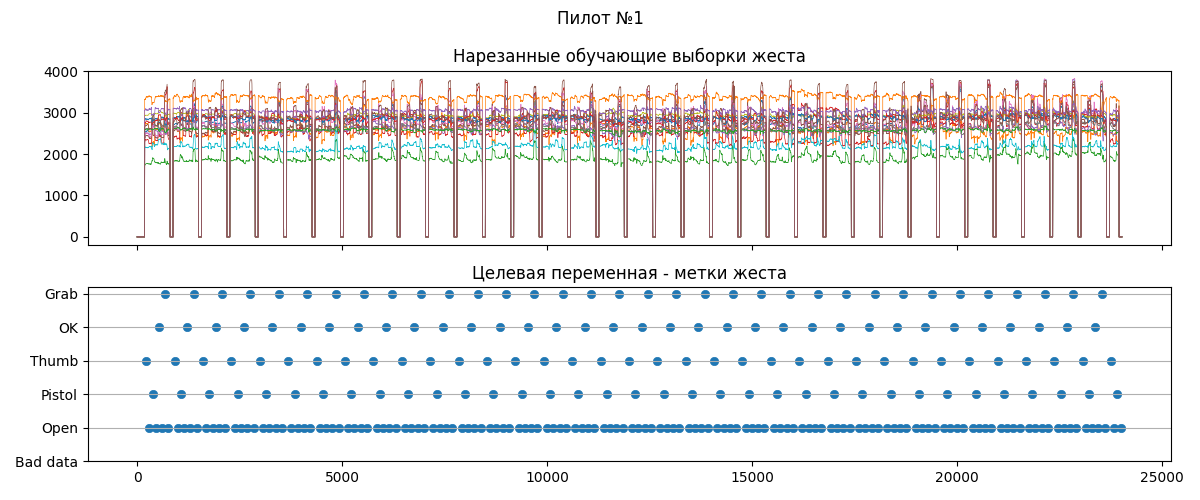

(1315, 16, 16) (1315, 16, 1) (1315, 16, 5)


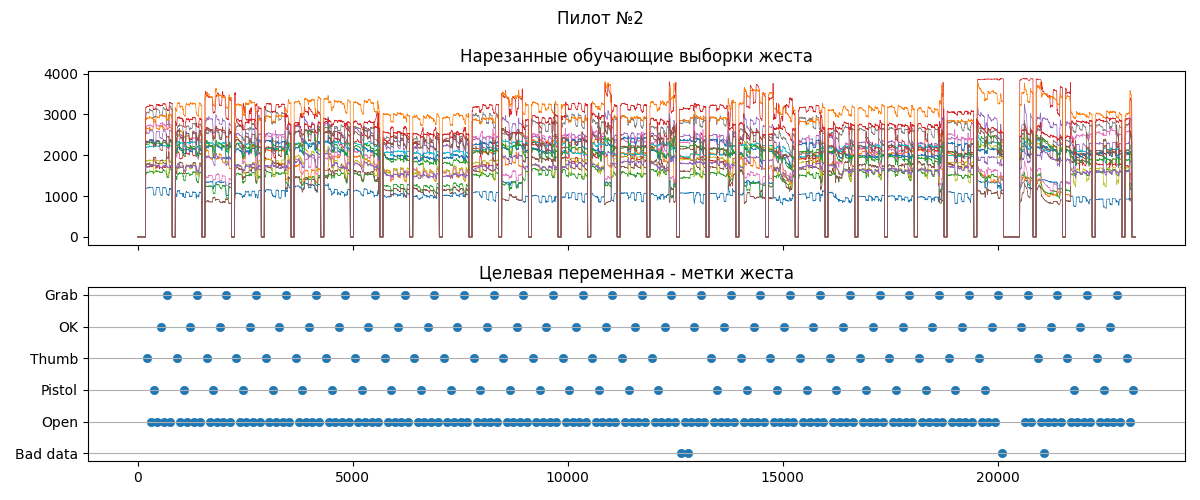

(1335, 16, 16) (1335, 16, 1) (1335, 16, 5)


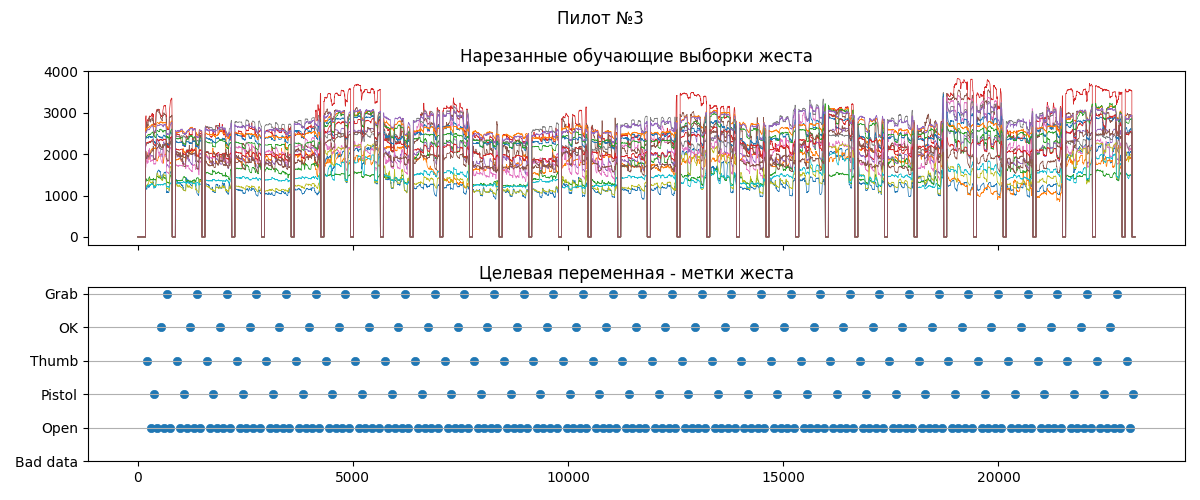

In [91]:
for mount_name, mount in mounts.items():
    X_train_sel = mount['X_train_sel']
    y_train = mount['y_train']
    events =  mount['events']
    events_b =  mount['events_b']
    events_e =  mount['events_e']
    
    n_samples = events.shape[0]   # количество жестов
    
    # Задаем форму массива целевой переменной для жеста
    y_train_gest = np.zeros(n_samples, dtype=int)
    
     # формируем метки жеста из значения целевой переменной 
     # со сдвигом от начала жеста для исключения влияния переходного процесса
    y_train_gest[:] = y_train[events_b+3]
    
    # Задаем форму массивов нарезанных обучающих выборок для жеста
    # Используется только для визуализации
    X_train_cut = np.zeros_like(X_train_sel)
    y_train_cut = np.zeros_like(y_train)
        
    # Зададим форму массива жеста
    X_train_nn_gest = np.zeros((n_samples, gest_len, N_sensors), dtype=int)
    y_train_nn_gest = np.zeros((n_samples, gest_len, 1), dtype=int)
    # Зададим форму массива окна
    X_train_nn_frame = np.zeros((n_samples, n_frames, n_ticks, N_sensors), dtype=int)
    y_train_nn_frame = np.zeros((n_samples, n_frames, n_ticks, 1), dtype=int)
    
    
    for i in range(n_samples-1):
        X_train_cut[events_b[i]:events_e[i]] = X_train_sel[events_b[i]:events_e[i]]
        y_train_cut[events_b[i]:events_e[i]] = np.full((gest_len), y_train_gest[i])
 
        X_train_nn_gest[i] = X_train_sel[events_b[i]:events_e[i]] # разделим входной массив на жесты
        
        # Создадим массив жеста целевой переменной, заполненный одним значением
        y_train_nn_gest[i] = np.full((gest_len, 1), y_train_gest[i])

    # Разделим массив жеста на массивы окон по числу окон n_frames
    for i in range(n_frames):
        X_train_nn_frame[:,i] = X_train_nn_gest[:, i*n_ticks:(i+1)*n_ticks]
        y_train_nn_frame[:,i] = y_train_nn_gest[:, i*n_ticks:(i+1)*n_ticks]
    # Создадим массивы для нейронной сети из нарезанных окон  
    X_train_nn = X_train_nn_frame.reshape(n_frames*n_samples, n_ticks, N_sensors)
    y_train_nn = y_train_nn_frame.reshape(n_frames*n_samples, n_ticks, 1)
       
    # Создадим массив целевой переменной в категориальной форме 
    # для нейронной сети 
    y_train_nn_cat = tf.keras.utils.to_categorical(y_train_nn)
    
    mount['X_train_nn'] = X_train_nn 
    mount['y_train_nn'] = y_train_nn
    mount['y_train_nn_cat'] = y_train_nn_cat
    
    print(X_train_nn.shape, y_train_nn.shape, y_train_nn_cat.shape)    
    

    # ВИЗУАЛИЗАЦИЯ
    fig, axx = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
    
    plt.sca(axx[0])
    plt.plot(X_train_cut, lw=0.5)
    plt.title('Нарезанные обучающие выборки жеста')
    yl = plt.ylim()
        
    plt.sca(axx[1])
    plt.scatter(events_b+gest_len/2, y_train_gest, lw=0.5)
    plt.title('Целевая переменная - метки жеста')
    yl = plt.ylim()
    plt.yticks(
        np.arange(-1, 5),
        ['Bad data', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
    )
    plt.grid(axis='y')

    plt.suptitle(f"Пилот №{mount_name}")
    plt.tight_layout()
    plt.show(); 

В данных присутствуют участки, помеченные *Bad data*. Проведем дополнительную очистку данных, удалив соответствующие выборки.

In [92]:
for mount_name, mount in mounts.items():
    X_train_nn = mount['X_train_nn']
    y_train_nn = mount['y_train_nn']
    y_train_nn_cat = mount['y_train_nn_cat']
      
    bad_list = [i for i, x in enumerate(y_train_nn) if -1 in x]
    
    X_train_nn = np.delete(X_train_nn, bad_list, axis=0)
    y_train_nn = np.delete(y_train_nn, bad_list, axis=0)
    y_train_nn_cat= np.delete(y_train_nn_cat, bad_list, axis=0)
    
    mount['X_train_nn'] = X_train_nn 
    mount['y_train_nn'] = y_train_nn
    mount['y_train_nn_cat'] = y_train_nn_cat   

Выделение валидационной выборки. При значении параметра функции *cr_val=False* происходит формирование одной валидационной выборки.  
При значении параметра функции *cr_val=True* происходит формирование выборок для кросс-валидации в соответствии с указанным значением фолдов.

In [93]:
for mount_name, mount in mounts.items():
    X_train_nn = mount['X_train_nn']
    y_train_nn = mount['y_train_nn']
    y_train_nn_cat = mount['y_train_nn_cat']
    splitted_Xy = cross_val_train_test_split(X_train_nn, y_train_nn, y_train_nn_cat, cr_val=True)
    mount['splitted_Xy'] = splitted_Xy

    print(f"Размер обучающей выборки {splitted_Xy[0][0].shape[0]}. Пилот №{mount_name}")
    print(f"Размер валидационной выборки {splitted_Xy[0][3].shape[0]}. Пилот №{mount_name}")

Кросс-валидация, количество фолдов 5
Размер обучающей выборки 1104. Пилот №1
Размер валидационной выборки 276. Пилот №1
Кросс-валидация, количество фолдов 5
Размер обучающей выборки 1036. Пилот №2
Размер валидационной выборки 259. Пилот №2
Кросс-валидация, количество фолдов 5
Размер обучающей выборки 1068. Пилот №3
Размер валидационной выборки 267. Пилот №3


## Модель

In [94]:
def init_keras_model(visible_summary = True):
    """Инициализация модели НС.

    Аргументы:
        visible_summary (bool): отображение структуры НС.
    
    Возвращает:
        model: модель НС.
            
    """
    output_units = y_train_nn_cat.shape[-1]
    input_channels = x = tf.keras.layers.Input(shape=(n_ticks, N_sensors))
    print(f"input_shape = {(n_ticks, N_sensors)} | output_units = {output_units}")
    x = tf.keras.layers.BatchNormalization()(input_channels)
    x = tf.keras.layers.SimpleRNN(
        units=300,
        return_sequences=True,
        recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-2, l2=1e-3),
        dropout=0.0,
        recurrent_dropout=0.0,
    )(x)
    x = tf.keras.layers.SimpleRNN(
        units=100,
        return_sequences=True,
        recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-2, l2=1e-3),
        dropout=0.0,
        recurrent_dropout=0.0,
    )(x)
    x = tf.keras.layers.Dense(100, activation='linear')(x)
    output = tf.keras.layers.Dense(units=output_units, activation='softmax')(x)

    model = tf.keras.Model(
        inputs=input_channels,
        outputs=output,
        name="Model"
    )
    if visible_summary:
        model.summary()
    return model

In [95]:
def fit_keras_model(model,
    X_tr, y_tr,
    learning_rate=1e-3,
    epochs=25,
    batch_size=30,
):
    """Обучение модели НС по параметрам.

    Аргументы:
        model: модель НС.
        X_tr: тренировочная выборка.
        y_tr: целевая переменная.
        learning_rate: скорость обучения, по-умолчанию 1e-3.
        epochs: количество эпох обучения, по-умолчанию 25.
        batch_size: размер batch'а, по-умолчанию 30.
        verbose: визуализация процесса обучения, по-умолчанию 0.
    
    Возвращает:
        model: обученная модель НС. 
        history: история обучения НС.
         
    """
    model.compile(
        loss="categorical_crossentropy",
        metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
        optimizer=tf.keras.optimizers.RMSprop(learning_rate),
    )
    
    history = model.fit(
        X_tr, y_tr, 
        epochs=epochs,
        batch_size=batch_size,
        # Set the verbosity level here! This is important.
        callbacks=[SelectiveProgbarLogger(verbose = 0)], 
        # This disables the default `ProgbarLogger`
        verbose=0
    )
    return model, history

In [96]:
def show_history(history):
    """Визуализация истории обучения НС.

    Строит график обучения НС, в завершении выводит значения precision 
    и recall для последней точки графика.

    Аргументы:
        history: история обучения НС.
    
    Возвращает:
        ничего.
    
    """
    _, precision, recall  = list(history.history.keys())
    global mount_name
    fig, ax = plt.subplots()
    ax.plot(history.history[precision], 
        label='precision на обучающем наборе')
    ax.plot(history.history[recall], 
        label='recall на обучающем наборе')
    ax.set_xlabel('Эпоха обучения')
    ax.set_ylabel('Значение метрики')
    ax.legend()
    plt.suptitle(f"Пилот №{mount_name}")

In [97]:
def train_and_evaluate_model(model, x_trn, x_val, y_trn, y_val, epochs_1=100):
    """Тренировка и оценка качества модели.

    Тренировка модели на наборе x_train и y_train, оценка качества модели
    на наборе x_test и y_test. Процесс обучения состоит из двух этапов:
    1. Обучение 25 эпох с learning_rate=1e-3.
    2. Дообучение модели 2 раза по 10 эпох с learning_rate=1e-3.

    Аргументы:
        model: модель НС.
        x_train: тренировочный набор признаков.
        x_test: тестовый набор признаков.
        y_train: тренировочная целевая переменная.
        y_test: тестовая целевая переменная.
    
    Возвращает:
        model:   обученная модель
        results: результат проверки тестовой выборки. Содержит
            loss, precision, recall.
            
    """
    
    
    # обучаем модель
    model, history = fit_keras_model(model,x_trn,y_trn, learning_rate=learning_rate_1, epochs=epochs_1)

    # дообучаем модель
    model, history = fit_keras_model(model,x_trn,y_trn, learning_rate=learning_rate_2, epochs=epochs_2)
    model, history = fit_keras_model(model,x_trn,y_trn, learning_rate=learning_rate_2, epochs=epochs_2)
    show_history(history) # график обучения

    # оценка качества модели на тестовых данных
    results = model.evaluate(x_val,y_val)
    
    
    return model, results


### Выполнение алгоритма кросс-валидации или валидации в зависимости от параметра *cr_val*, выбранного при разделении выборки

In [98]:
for mount_name, mount in mounts.items():
    print('n_frames =',n_frames, '  n_ticks =', n_ticks )
    splitted_Xy = mounts[mount_name]['splitted_Xy']
    epochs_1 = mount['epochs_1']


    results = []
    for kfold_x, kfold_x_test, kfold_y, kfold_y_test in splitted_Xy:
        #model = None
        model = init_keras_model(visible_summary=False)
        model_CV, curr_result = train_and_evaluate_model(model, kfold_x, kfold_x_test,
                                                        kfold_y, kfold_y_test, epochs_1)
        results.append(curr_result)
        
    mounts[mount_name]['results'] = results
    mounts[mount_name]['model_CV'] = model_CV

In [100]:
for mount_name, mount in mounts.items():
    results = mounts[mount_name]['results']
        
    print(f"ПИЛОТ №{mount_name}, метрики по фолдам:")
    for i in range(len(results)):
        print(f'{i+1}.  {results[i]}')
    if len(results) != 1:
        print(f'ПИЛОТ №{mount_name}, средние значения метрик по фолдам:\n{np.mean(results, axis=0)}')
        
print(f'n_frames={n_frames}  n_ticks={n_ticks}')

## Тренировка модели.

input_shape = (16, 16) | output_units = 5
Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 16, 16)]          0         
                                                                 
 batch_normalization_13 (Bat  (None, 16, 16)           64        
 chNormalization)                                                
                                                                 
 simple_rnn_26 (SimpleRNN)   (None, 16, 300)           95100     
                                                                 
 simple_rnn_27 (SimpleRNN)   (None, 16, 100)           40100     
                                                                 
 dense_26 (Dense)            (None, 16, 100)           10100     
                                                                 
 dense_27 (Dense)            (None, 16, 5)             505       
                   

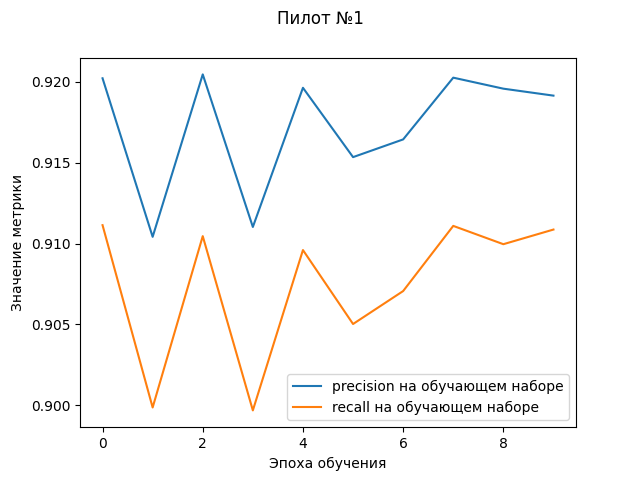

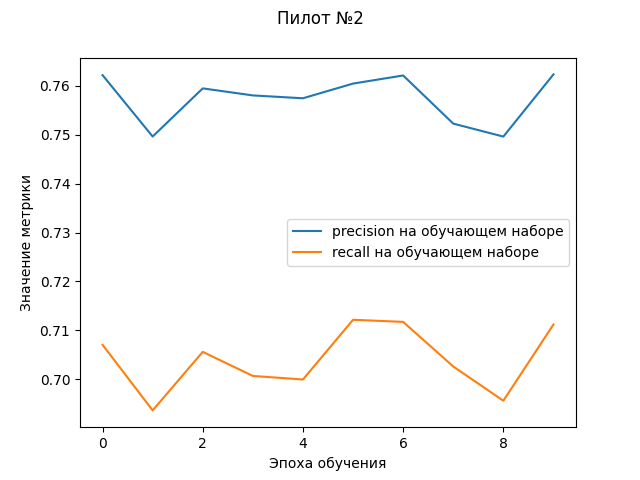

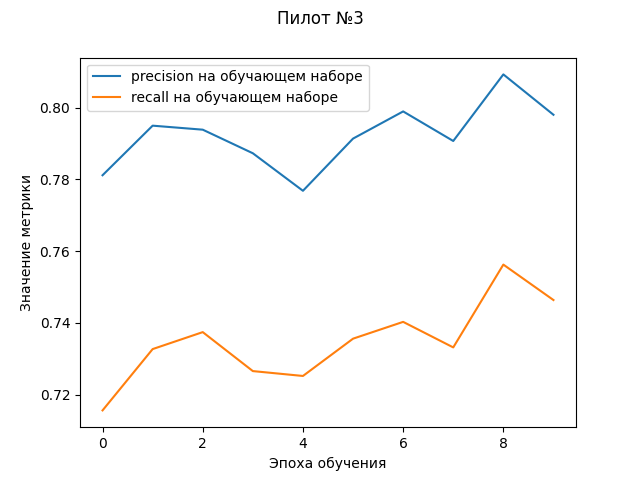

In [101]:
for mount_name, mount in mounts.items():
    X_train_nn = mount['X_train_nn']
    y_train_nn_cat = mount['y_train_nn_cat']
    epochs_1 = mount['epochs_1']
    
    nn_model = init_keras_model()
    

    m, nn_result = train_and_evaluate_model(
        nn_model,
        X_train_nn, X_train_nn, y_train_nn_cat, y_train_nn_cat,
        epochs_1
    )
    
    nn_loss, nn_precision, nn_recall = nn_result
    
    mount['model'] = m
    # сохраняем модель в файл
    #m.save(str(mount_name)+str(name)+".h5")
    
    mount['nn_precision'] = nn_precision
    mount['nn_recall'] = nn_recall


In [102]:
for mount_name, mount in mounts.items():
    nn_precision = mount['nn_precision']
    nn_recall = mount['nn_recall']
    
    print(f"Пилот № {mount_name} \nМетрики:\nPresicion: {nn_precision}\nRecall: {nn_recall}")

Пилот № 1 
Метрики:
Presicion: 0.8929570913314819
Recall: 0.8814311623573303
Пилот № 2 
Метрики:
Presicion: 0.785427451133728
Recall: 0.7267857193946838
Пилот № 3 
Метрики:
Presicion: 0.8476031422615051
Recall: 0.8087546825408936


Обучение происходит на вырезанных участках обучающей выборки. Для предварительного подбора параметров сделаем предикт всех обучающих выборок и посчитаем долю правильно предсказанных классов.

In [103]:
# предикт всего трейна
for mount_name, mount in mounts.items():
    X_train_sel = mount['X_train_sel']
    y_train = mount['y_train']
    m = mount['model']
    y_pred_train=get_predict_FR(X_train_sel, m, n_ticks)
    mount['y_pred_train'] = y_pred_train


In [104]:
# # Создадим файлы для сохранения параметров. 
# # После создания закомментируем эту ячейку, чтобы сохранять прежние данные.
# for mount_name, mount in mounts.items():
#     srs_param = pd.Series({'n_frames':'Количество окон',
#                         'n_ticks':'Тиков в окне',
#                         'shift_gest_beg':'Сдвиг',
#                         'learning_rate_1':'Скорость обучения',
#                         'learning_rate_2':'Скорость дообучения',
#                         'epochs_1':'Эпох обучения',
#                         'epochs_2':'Эпох дообучения',
#                         'metric_':'метрика'})
#     mount['srs_param'] = srs_param
#     file_name = 'PARAM_'+str(mount_name)+'.csv'
#     srs_param.to_csv(file_name, encoding='utf-8-sig')

In [105]:
# подсчет доли совпадений классов
for mount_name, mount in mounts.items():
    y_pred_train = mount['y_pred_train']
    y_train = mount['y_train']
    
    metric_ = len(np.where(y_train-y_pred_train == 0)[0])/len(y_train)
    mount['metric_'] = metric_
    print(metric_)

0.8040366208905535
0.7054564261701577
0.7953143202312638


In [106]:
for mount_name, mount in mounts.items():
    
    df_param = pd.read_csv('PARAM_'+str(mount_name)+'.csv')
    srs_param_curr = pd.Series([n_frames,
                            n_ticks,
                            mount['shift_gest_beg'],
                            learning_rate_1,
                            learning_rate_2,
                            mount['epochs_1'],
                            epochs_2,
                            mount['metric_']])
    
    df_param = pd.concat([df_param, srs_param_curr], axis=1, ignore_index=True)
    mount['df_param'] = df_param
    file_name = 'PARAM_'+str(mount_name)+'.csv'
    df_param.to_csv(file_name, encoding='utf-8-sig', index=False)

In [107]:
for mount_name, mount in mounts.items():
    print(f'Таблица для подбора параметров пилота №{mount_name}')
    df_param = pd.read_csv('PARAM_'+str(mount_name)+'.csv')
    display(df_param.drop(['0','9'],axis=1))

Таблица для подбора параметров пилота №1


1           2           3           4           5  \
0      Количество окон    7.000000    5.000000    5.000000    5.000000   
1         Тиков в окне   12.000000   16.000000   16.000000   16.000000   
2                Сдвиг   10.000000    8.000000    7.000000    5.000000   
3    Скорость обучения    0.010000    0.010000    0.010000    0.010000   
4  Скорость дообучения    0.001000    0.001000    0.001000    0.001000   
5        Эпох обучения  100.000000  100.000000  100.000000  100.000000   
6      Эпох дообучения   10.000000   10.000000   10.000000   10.000000   
7              метрика    0.791261    0.816854    0.825551    0.826051   

            6           7           8          10          11  ...  \
0    5.000000    5.000000    5.000000    5.000000    5.000000  ...   
1   16.000000   16.000000   16.000000   16.000000   16.000000  ...   
2    4.000000    5.000000    5.000000    5.000000    5.000000  ...   
3    0.010000    0.010000    0.010000    0.010000    0.010000  ...   
4    0.001000    0.001000    0.001000    0.001000    0.001000  ...   
5  100.000000  150.000000  200.000000  140.000000  150.000000  ...   
6   10.000000   10.000000   10.000000   10.000000   10.000000  ...   
7    0.796796    0.815897    0.815897    0.811943    0.813566  ...   

           23          24          25          26          27          28  \
0    5.000000    5.000000    5.000000    5.000000    5.000000    6.000000   
1   16.000000   16.000000   16.000000   17.000000   16.000000   13.000000   
2    9.000000   11.000000   10.000000   10.000000   10.000000   10.000000   
3    0.010000    0.010000    0.010000    0.010000    0.010000    0.010000   
4    0.001000    0.001000    0.001000    0.001000    0.001000    0.001000   
5  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
6   10.000000   10.000000   10.000000   10.000000   10.000000   10.000000   
7    0.818477    0.800416    0.804037    0.793425    0.804037    0.808489   

           29          30          31          32  
0    6.000000    6.000000    7.000000    5.000000  
1   14.000000   15.000000   14.000000   16.000000  
2   10.000000   10.000000   10.000000   10.000000  
3    0.010000    0.010000    0.010000    0.010000  
4    0.001000    0.001000    0.001000    0.001000  
5  100.000000  100.000000  100.000000  100.000000  
6   10.000000   10.000000   10.000000   10.000000  
7    0.786517    0.783104    0.766958    0.804037  

[8 rows x 31 columns]

Таблица для подбора параметров пилота №2


1          2           3           4           5  \
0      Количество окон    7.00000    5.000000    5.000000    5.000000   
1         Тиков в окне   12.00000   16.000000   16.000000   16.000000   
2                Сдвиг    5.00000    3.000000    2.000000    4.000000   
3    Скорость обучения    0.01000    0.010000    0.010000    0.010000   
4  Скорость дообучения    0.00100    0.001000    0.001000    0.001000   
5        Эпох обучения  100.00000  100.000000  100.000000  100.000000   
6      Эпох дообучения   10.00000   10.000000   10.000000   10.000000   
7              метрика    0.70481    0.706146    0.690156    0.707008   

            6           7           8          10          11  ...  \
0    5.000000    5.000000    5.000000    5.000000    5.000000  ...   
1   16.000000   16.000000   16.000000   16.000000   16.000000  ...   
2    3.000000    4.000000    4.000000    4.000000    4.000000  ...   
3    0.010000    0.010000    0.010000    0.010000    0.010000  ...   
4    0.001000    0.001000    0.001000    0.001000    0.001000  ...   
5  100.000000  150.000000  200.000000  140.000000  160.000000  ...   
6   10.000000   10.000000   10.000000   10.000000   10.000000  ...   
7    0.700715    0.720972    0.710542    0.692009    0.702569  ...   

           23          24          25          26          27          28  \
0    5.000000    5.000000    5.000000    5.000000    5.000000    6.000000   
1   16.000000   16.000000   16.000000   17.000000   16.000000   13.000000   
2    4.000000    5.000000    6.000000    5.000000    5.000000    5.000000   
3    0.010000    0.010000    0.010000    0.010000    0.010000    0.010000   
4    0.001000    0.001000    0.001000    0.001000    0.001000    0.001000   
5  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
6   10.000000   10.000000   10.000000   10.000000   10.000000   10.000000   
7    0.700155    0.705456    0.703819    0.708086    0.710284    0.709422   

           29          30          31          32  
0    6.000000    6.000000    7.000000    5.000000  
1   14.000000   15.000000   14.000000   16.000000  
2    5.000000    5.000000    5.000000    5.000000  
3    0.010000    0.010000    0.010000    0.010000  
4    0.001000    0.001000    0.001000    0.001000  
5  100.000000  100.000000  100.000000  100.000000  
6   10.000000   10.000000   10.000000   10.000000  
7    0.708086    0.704896    0.683432    0.705456  

[8 rows x 31 columns]

Таблица для подбора параметров пилота №3


1           2           3           4           5  \
0      Количество окон    7.000000    5.000000    5.000000    5.000000   
1         Тиков в окне   12.000000   16.000000   16.000000   16.000000   
2                Сдвиг    5.000000    3.000000    2.000000    4.000000   
3    Скорость обучения    0.010000    0.010000    0.010000    0.010000   
4  Скорость дообучения    0.001000    0.001000    0.001000    0.001000   
5        Эпох обучения  100.000000  100.000000  100.000000  100.000000   
6      Эпох дообучения   10.000000   10.000000   10.000000   10.000000   
7              метрика    0.788713    0.779782    0.783061    0.781206   

            6           7           8          10          11  ...  \
0    5.000000    5.000000    5.000000    5.000000    5.000000  ...   
1   16.000000   16.000000   16.000000   16.000000   16.000000  ...   
2    3.000000    4.000000    4.000000    4.000000    4.000000  ...   
3    0.010000    0.010000    0.010000    0.010000    0.010000  ...   
4    0.001000    0.001000    0.001000    0.001000    0.001000  ...   
5  100.000000  150.000000  200.000000  210.000000  220.000000  ...   
6   10.000000   10.000000   10.000000   10.000000   10.000000  ...   
7    0.772965    0.791259    0.801441    0.811624    0.803598  ...   

           23          24         25          26          27          28  \
0    5.000000    5.000000    5.00000    5.000000    5.000000    6.000000   
1   16.000000   16.000000   16.00000   17.000000   16.000000   13.000000   
2    4.000000    5.000000    6.00000    5.000000    5.000000    5.000000   
3    0.010000    0.010000    0.01000    0.010000    0.010000    0.010000   
4    0.001000    0.001000    0.00100    0.001000    0.001000    0.001000   
5  100.000000  100.000000  100.00000  100.000000  100.000000  100.000000   
6   10.000000   10.000000   10.00000   10.000000   10.000000   10.000000   
7    0.778876    0.795314    0.78017    0.787462    0.795314    0.781033   

           29         30          31          32  
0    6.000000    6.00000    7.000000    5.000000  
1   14.000000   15.00000   14.000000   16.000000  
2    5.000000    5.00000    5.000000    5.000000  
3    0.010000    0.01000    0.010000    0.010000  
4    0.001000    0.00100    0.001000    0.001000  
5  100.000000  100.00000  100.000000  100.000000  
6   10.000000   10.00000   10.000000   10.000000  
7    0.779868    0.77797    0.750831    0.795314  

[8 rows x 31 columns]

## Визуализация

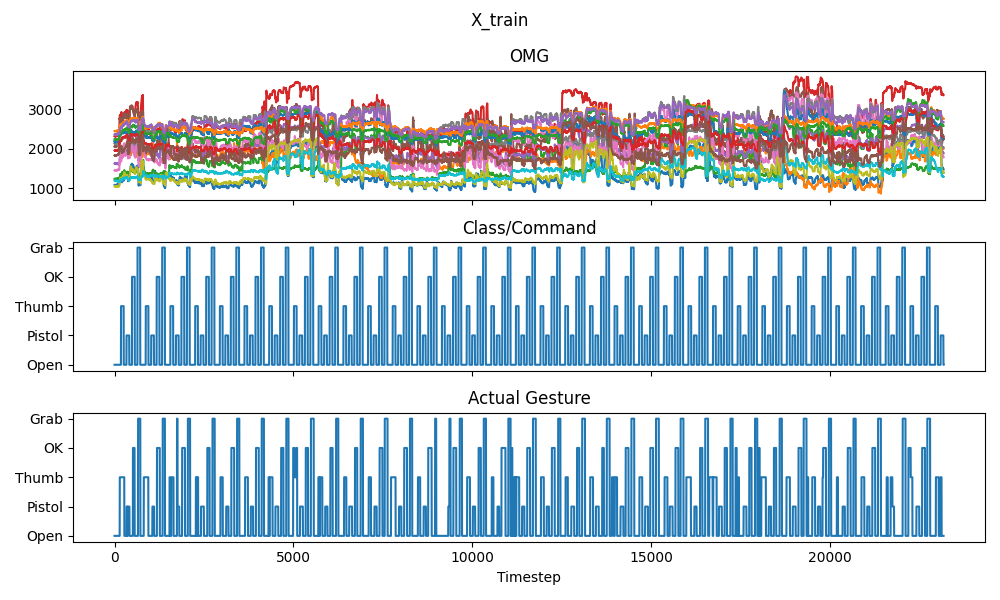

In [108]:
# ВИЗУАЛИЗАЦИЯ
fig, axx = plt.subplots(3, 1, sharex=True, figsize=(10, 6))

axx[0].plot(X_train_sel)
axx[0].set_title('OMG')

axx[1].plot(y_train)
axx[1].set_aspect('auto')
axx[1].set_title('Class/Command')
axx[1].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)

axx[2].plot(np.arange(len(y_pred_train[0])), y_pred_train[0])
axx[2].set_aspect('auto')
axx[2].set_title('Actual Gesture')
axx[2].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)
axx[2].set_xlabel('Timestep')

plt.suptitle('X_train')
plt.tight_layout()

In [109]:
# Отфильтруем тестовые выборки
for mount_name, mount in mounts.items():
    X_test_dataset = mount['X_test_dataset']
    X_test_sel = X_test_dataset.copy()
    for i in range(len(X_test_dataset)):
        X_test_sel[i] = X_test_dataset[i][list(activ_sens_set_comm), :]
    mount['X_test_sel'] = X_test_sel  

In [110]:
# Сформируем предикт произвольного сэмпла тестовой выборки и визуализируем его
with open('b:/Hacathon/3 task/XT_1.pkl', 'rb') as f:
        XTrd = pickle.load(f)
X_test_i = mounts[1]['X_test_sel'][5].swapaxes(0, 1)
m = mounts[1]['model']
y_pred_test = get_predict_FR(X_test_i, m, n_ticks)
y_pred_df = pd.DataFrame(y_pred_test)


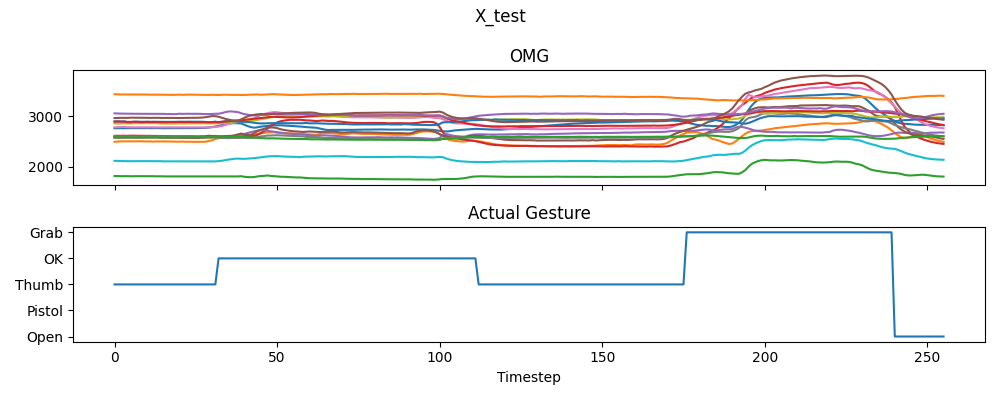

In [111]:
# ВИЗУАЛИЗАЦИЯ
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 4))

axx[0].plot(X_test_i)
axx[0].set_title('OMG')

# axx[1].plot(y_train[200:1200])
# axx[1].set_aspect('auto')
# axx[1].set_title('Class/Command')
# axx[1].set_yticks(
#     np.arange(5),
#     ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
# )

axx[1].plot(np.arange(len(y_pred_test[0])), y_pred_test[0])
axx[1].set_aspect('auto')
axx[1].set_title('Actual Gesture')
axx[1].set_yticks(
    np.arange(5),
    ['Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)
axx[1].set_xlabel('Timestep')

plt.suptitle('X_test')
plt.tight_layout()

## Изучим `X_test_dataset`

In [112]:
# Изучим тестовые данные
for mount_name, mount in mounts.items():
    
    with open(mount['path_X_test_dataset'], 'rb') as f:
        mount['X_test_dataset'] = pickle.load(f)
    print(f"Тестовый датасет пилота №{mount_name} представляет собой список из массивов длиной {len(mount['X_test_dataset'])}.")

Тестовый датасет пилота №1 представляет собой список из массивов длиной 899.
Тестовый датасет пилота №2 представляет собой список из массивов длиной 855.
Тестовый датасет пилота №3 представляет собой список из массивов длиной 861.


In [113]:
for mount_name, mount in mounts.items():
    X_test_dataset = mount['X_test_dataset']
    print(f"Пилот № {mount_name}")
    shapes, counts = np.unique(
        [arr.shape for arr in X_test_dataset],
        return_counts=True,
        axis=0
    )
    for shape, count in zip(shapes, counts):
        print(f"\tshape {tuple(shape)} appears {count} times.")

Пилот № 1
	shape (50, 105) appears 303 times.
	shape (50, 181) appears 299 times.
	shape (50, 256) appears 297 times.
Пилот № 2
	shape (50, 105) appears 286 times.
	shape (50, 181) appears 285 times.
	shape (50, 256) appears 284 times.
Пилот № 3
	shape (50, 105) appears 291 times.
	shape (50, 181) appears 282 times.
	shape (50, 256) appears 288 times.


Визуализация отфильтрованных тестовых выборок

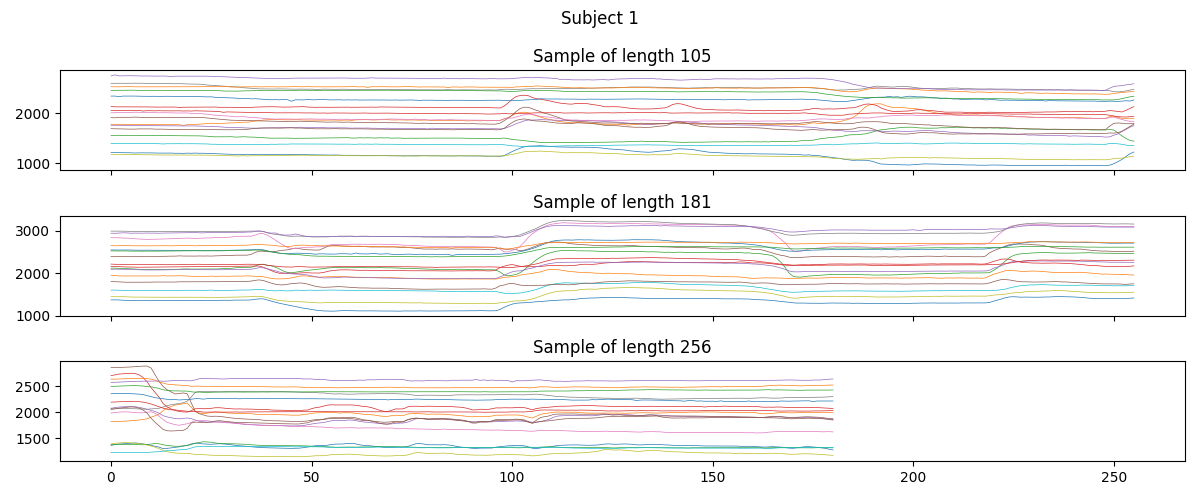

In [114]:
for mount_name, mount in mounts.items():
    
    fig, axx = plt.subplots(3, 1, sharex=True, figsize=(12, 5))
    plt.sca(axx[0])
    plt.plot(X_test_sel[3].T, lw=0.5)
    plt.title('Sample of length 105')
    
    plt.sca(axx[1])
    plt.plot(X_test_sel[1].T, lw=0.5)
    plt.title('Sample of length 181')
    
    plt.sca(axx[2])
    plt.plot(X_test_sel[8].T, lw=0.5)
    plt.title('Sample of length 256')
    
    plt.suptitle(f"Subject {mount_name}")
    plt.tight_layout()
    plt.show()
    
    break;

Формируем submission

In [115]:
# Загрузим образец submission
y_test_subm = pd.read_csv('./sample_submission.csv')

print(y_test_subm.shape)
y_test_subm.head()

(471610, 2)


subject_id-sample-timestep  class
0                      1-0-0      4
1                      1-0-1      2
2                      1-0-2      0
3                      1-0-3      0
4                      1-0-4      3

In [116]:
# Формируем submission
for mount_name, mount in mounts.items():
    m = mount['model']
    X_test_sel = mount['X_test_sel']
    
    y_pred = np.zeros((1, 1))
    for i in range(len(X_test_sel)):
        X_test_i = X_test_sel[i].swapaxes(0, 1)
        y_pred_i = get_predict_FR(X_test_i, m, n_ticks)
        y_pred = np.hstack((y_pred, y_pred_i))
    y_pred = np.delete(y_pred, 0, axis=1).astype(int)    
    mount['y_pred_test'] = y_pred
    
y_pred_test_res = np.concatenate([mounts[1]['y_pred_test'], mounts[2]['y_pred_test'], mounts[3]['y_pred_test']], axis=1).astype(int)

y_test_subm['class'] = y_pred_test_res.T
    
y_test_subm['class'] = y_pred_test_res
y_test_subm.to_csv('./y_test_submit.csv', index=False) 

KeyboardInterrupt: 